In [42]:
#!pip install pandas
#!pip install matplotlib
#!pip install sklearn

In [41]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU') 

if len(gpus)==0:
    print("no gpu")
else:
    print("GPU: %s", gpus)

GPU: %s [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import pandas as pd
import numpy as np

filename = "cars.csv"

dtypes = {
    "maker": str,
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str,
    "color_slug": str,
    "stk_year": str,
    "transmission": str,
    "door_count": str,
    "seat_count": str,
    "fuel_type": str,
    "date_created": str,
    "date_last_seen": str,
    "price_eur": float}

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [11]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [12]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 200.00]

print(df.isna().sum())

maker                   462087
model                  1008763
mileage                 174222
manufacture_year        257363
engine_displacement     513390
engine_power            355237
body_type              1122329
color_slug             2801332
stk_year               1133276
transmission            354416
door_count              214350
seat_count              352762
fuel_type              1493871
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [13]:
df.describe()

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,2.662996e+06,2.579855e+06,2.323828e+06,2.481981e+06,2.837218e+06
mean,1.036281e+05,2.005297e+03,1.972952e+03,9.950409e+01,2.035618e+06
std,3.071016e+05,5.402212e+01,1.661741e+03,4.956741e+01,2.266753e+09
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000400e+02
25%,1.586800e+04,2.005000e+03,1.398000e+03,6.900000e+01,4.480000e+03
50%,7.515000e+04,2.010000e+03,1.796000e+03,8.800000e+01,1.060000e+04
75%,1.450000e+05,2.014000e+03,1.997000e+03,1.150000e+02,1.881503e+04
max,9.999999e+06,2.016000e+03,3.200000e+04,1.504000e+03,2.706149e+12


In [14]:
df = df[df['fuel_type'].notna()]
df = pd.get_dummies(df,columns=["fuel_type"])

df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])

#TODO: dopo la foresta
year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].\
groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# df = df[df['seat_count'].notna()]
# df = df[df['door_count'].notna()]

features_to_fillna = ["door_count", "seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduce the median
    df[feature].fillna(replace_with,inplace=True)             # replace null

df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)

# Engine Power
scepticism = 50
average = df.loc[df["engine_power"] >= scepticism].\
groupby(["maker", "model"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_power"] < scepticism, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Disp
scepticism = 600
average = df.loc[df["engine_displacement"] >= scepticism].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < scepticism, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["engine_displacement"])
df = df[df['engine_displacement'].notna()]

features_to_fillna = ["mileage" ] # , "engine_displacement","engine_power"
for feature in features_to_fillna:
    replace_with = df[feature].mean() # deduce the mean
    # replace_with = df[feature].median() # deduce the median 
    # replace_with = df[feature].mode() # deduce the mode
    df[feature].fillna(replace_with,inplace=True)
    
# let's transform str dates in datetimes and creare a new feature with the duration of the ad
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_power", "avg_engine_displacement"]
df = df.drop(features_to_drop, axis="columns")

In [15]:
# df.sort_values(by=['price_eur']).head(500)

In [16]:
# features_to_drop = ["date_created", "date_last_seen"]
# df = df.drop(features_to_drop, axis="columns")

df_with_maker = df[df['maker'].notna()]
df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
df_no_maker.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654928 entries, 0 to 1011282
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   maker                654928 non-null  object 
 1   mileage              654928 non-null  float64
 2   manufacture_year     654928 non-null  float64
 3   engine_displacement  654928 non-null  float64
 4   engine_power         654928 non-null  float64
 5   price_eur            654928 non-null  float64
 6   fuel_type_diesel     654928 non-null  uint8  
 7   fuel_type_gasoline   654928 non-null  uint8  
 8   transmission_auto    654928 non-null  uint8  
 9   transmission_man     654928 non-null  uint8  
 10  seat_str_large       654928 non-null  uint8  
 11  seat_str_medium      654928 non-null  uint8  
 12  seat_str_small       654928 non-null  uint8  
 13  ad_duration          654928 non-null  int64  
dtypes: float64(5), int64(1), object(1), uint8(7)
memory usage: 44.3+ MB

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [27]:
print("Numero totale di proprietà: "+str(X_train.shape[1]))
print("Esempi di training: "+str(X_train.shape[0]))
print("Esempi di test: "+str(X_test.shape[0]))

num_classes = df_with_maker['maker'].nunique()
print("Numero Marchi Automobilistici:", str(num_classes))

from tensorflow.keras.utils import to_categorical

y_train_dummy = to_categorical(Y_train, num_classes)
y_test_dummy = to_categorical(Y_test, num_classes)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(num_classes, activation='softmax'))

##ACCURACY: TRAIN=0.9577 TEST=0.9117

Numero totale di proprietà: 13
Esempi di training: 589435
Esempi di test: 65493
Numero Marchi Automobilistici: 36


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               7168      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 36)                4644      
Total params: 176,036
Trainable params: 176,036
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

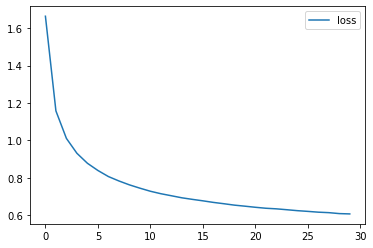

589435/589435 [==============================] - 45s 77us/sample - loss: 0.6061 - accuracy: 0.8002


In [30]:
model.fit(X_train, y_train_dummy, epochs=30, callbacks=[plot_losses])

In [35]:
model.evaluate(X_test, y_test_dummy)

65493/65493 [==============================] - 3s 51us/sample - loss: 0.6610 - accuracy: 0.7942


[0.6610290555724054, 0.7941612]

In [36]:
loss, acc = model.evaluate(X_test, y_test_dummy)
print("Loss sul test set: %.4f" % loss)
print("Accuracy sul test set: %.4f" % acc)

65493/65493 [==============================] - 3s 48us/sample - loss: 0.6610 - accuracy: 0.7942
Loss sul test set: 0.6610
Accuracy sul test set: 0.7942


In [150]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = model.predict_classes(df_no_maker)
prediction

array([30, 30, 30, ..., 27, 16, 16])

In [151]:
prediction = le.inverse_transform(prediction)
prediction

array(['skoda', 'skoda', 'skoda', ..., 'porsche', 'lamborghini',
       'lamborghini'], dtype=object)

In [152]:
df_no_maker.insert(0, 'maker', prediction)
df_no_maker.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man,seat_str_large,seat_str_medium,seat_str_small,ad_duration
9,skoda,301381.0,2002.0,1900.0,88.0,1332.35,1,0,0,1,0,1,0,74
10,skoda,202136.0,2002.0,1400.0,55.0,740.19,0,1,0,1,0,1,0,74
11,skoda,263840.0,1998.0,1900.0,81.0,999.26,1,0,0,1,0,1,0,74
12,audi,105394.0,2000.0,1360.0,55.0,1665.43,0,1,0,1,0,1,0,74
16,audi,115879.0,2003.0,1900.0,88.0,2220.58,1,0,0,1,0,1,0,74


In [153]:
frames = [df_with_maker, df_no_maker]
df = pd.concat(frames)
df.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man,seat_str_large,seat_str_medium,seat_str_small,ad_duration
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,1,0,0,1,1,0,0,74
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,1,0,0,1,0,1,0,74
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,1,0,0,1,0,1,0,74
3,skoda,111970.0,2004.0,1200.0,64.0,2960.77,0,1,0,1,0,1,0,74
4,skoda,128886.0,2004.0,1200.0,64.0,2738.71,0,1,0,1,0,1,0,74


In [154]:
df_exper = df.copy()

In [155]:
df_final = pd.get_dummies(df,columns=["maker"])
#df_final = df.drop("maker", axis=1)

In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop("price_eur", axis=1).values
Y = df_final["price_eur"].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 323579815.7589276
R2 score: 0.3460333919391285


In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
#R2 score: 0.7628874719468213
df_final.shape[0]

MSE: 0.2355929546631134
R2 score: 0.7557791683467578


867800

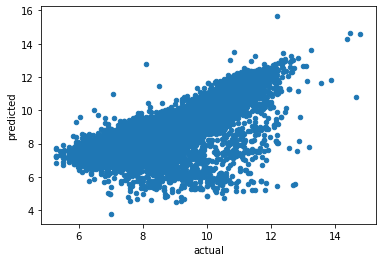

In [158]:
actual_predicted = pd.DataFrame({"predicted": ll.predict(X_test), 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")

In [159]:
df_exper = df_final.copy()

from scipy import stats

df_exper = df_exper\
    .loc[:, lambda df: df.std() > 0.05]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_exper.drop("price_eur", axis=1).values
Y = np.log1p(df_exper["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
#R2 score: 0.8904640737775003
df_exper.shape[0]

MSE: 0.09257015041420488
R2 score: 0.8704140375764662


261468

In [161]:
df_dl= df_final.copy()

from scipy import stats

df_dl = df_dl\
    .loc[:, lambda df: df.std() > 0.05]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_dl.drop("price_eur", axis=1).values
Y = np.log1p(df_dl["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1]))
model.add(Dense(256, input_dim=X_train.shape[1]))
model.add(Dense(128, input_dim=X_train.shape[1]))
model.add(Dense(1, ))

model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=2)

Epoch 1/2
7354/7354 [==============================] - 9s 1ms/step - loss: nan
Epoch 2/2
7354/7354 [==============================] - 8s 1ms/step - loss: nan


In [164]:
mse = model.evaluate(X_test,Y_test)
print("MSE sul test set: %.4f" % mse)

Y_pred = model.predict(X_test)
r2_score(Y_test, Y_pred)

818/818 [==============================] - 1s 723us/step - loss: nan
MSE sul test set: nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

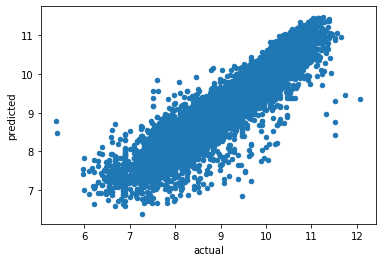

In [160]:
actual_predicted = pd.DataFrame({"predicted": Y_pred, 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")